In [24]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture as GMM

In [2]:
# read csv/excel data files 
pnas_data1 = pd.read_csv('/home/jaeweon/research/data/pnas_data1.csv')
pnas_data2 = pd.read_csv('/home/jaeweon/research/data/pnas_data2.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [51]:
# format data 

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']

# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = pnas_data1.loc[:, features].values
scaled = StandardScaler().fit_transform(data_mat)
P, D, Q = svd(scaled)
data = np.matmul(scaled, Q.T) # data matrix is obtained by multiplying initial data matrix with SVD column matrix

print(pnas_data1[7866:8280])

                             NGA    PolID  Time    PolPop   PolTerr    CapPop  \
7865        Yemeni Coastal Plain  YeOttoL  1900  4.608744  5.226207  4.242583   
7866           Big Island Hawaii  Hawaii1  1000  2.897659  2.163165  1.816843   
7867           Big Island Hawaii  Hawaii2  1200  3.573096  3.132700  2.430693   
7868           Big Island Hawaii  Hawaii2  1300  4.066598  3.132700  3.529154   
7869           Big Island Hawaii  Hawaii2  1400  4.179210  3.132700  2.792546   
7870           Big Island Hawaii  Hawaii2  1500  4.609672  3.132700  1.992660   
7871           Big Island Hawaii  Hawaii2  1600  3.578784  3.132700  1.525743   
7872           Big Island Hawaii  Hawaii3  1700  5.200054  3.958364  3.636157   
7873           Big Island Hawaii  USKameh  1800  5.242720  4.206549  3.659257   
7874                     Cahokia  USMisEW  -600  1.715790  1.780346  1.586054   
7875                     Cahokia  USMisMW  -100  1.687880  1.309944  1.648868   
7876                     Cah

In [10]:
def svd(data):
    """
    perform singular value decomposition on the given data matrix
    """
    #center the data
    mean = np.mean(data, axis=0)
    data -= mean
    
    P, D, Q = np.linalg.svd(data, full_matrices=False)
    
    return P, D, Q

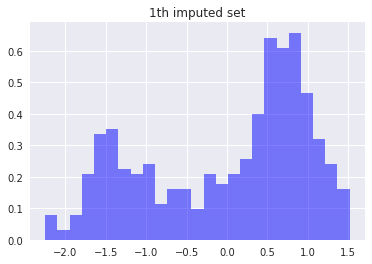

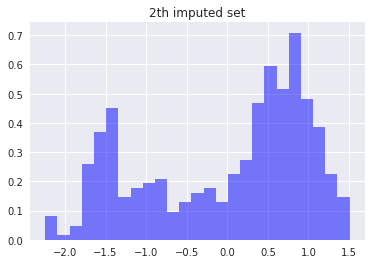

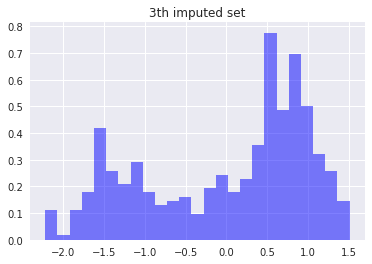

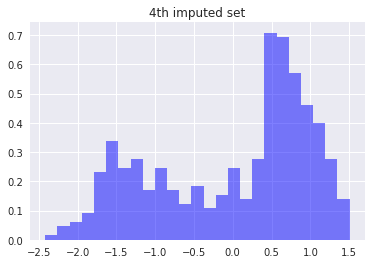

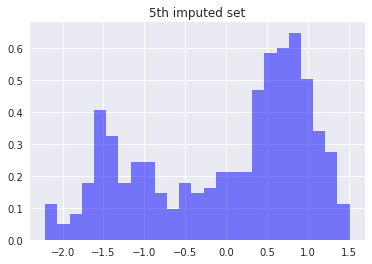

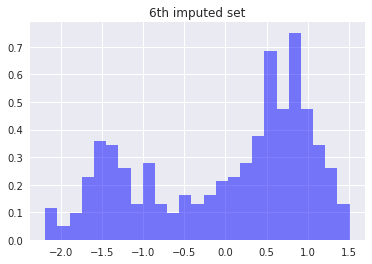

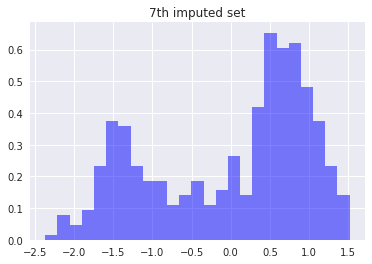

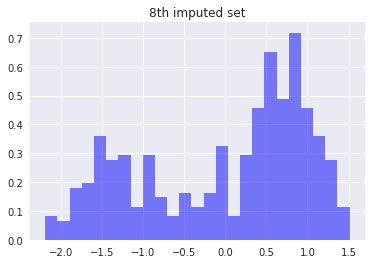

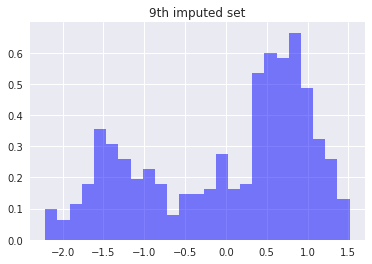

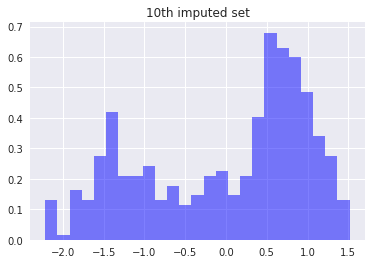

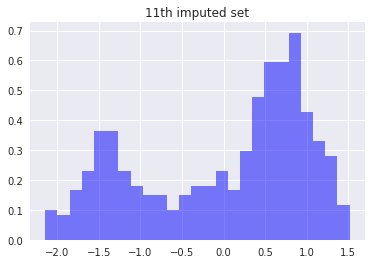

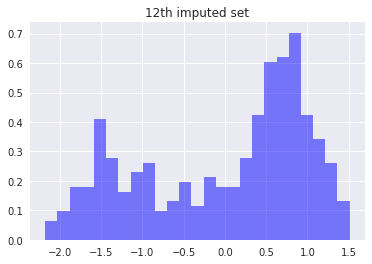

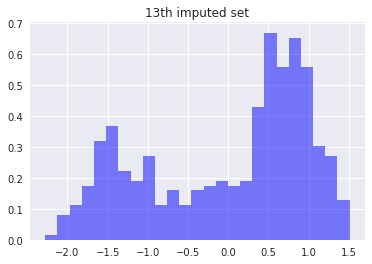

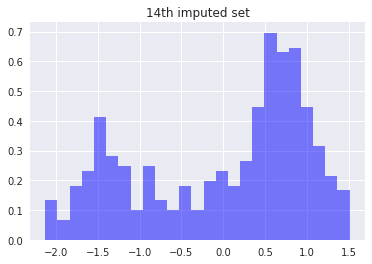

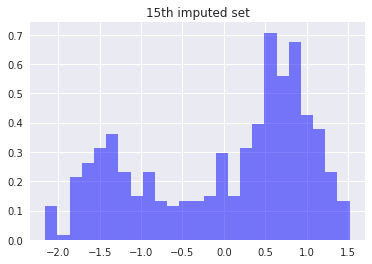

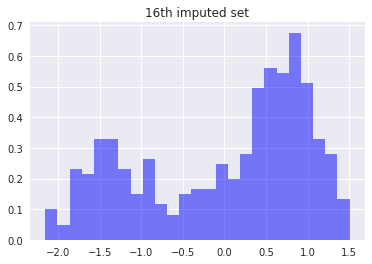

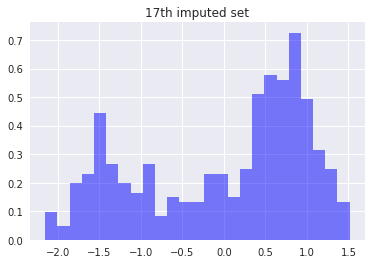

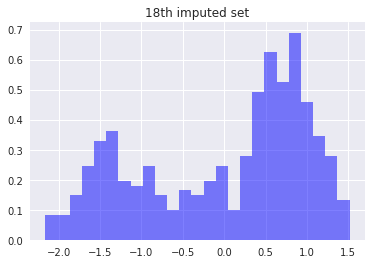

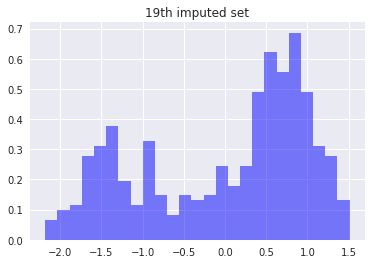

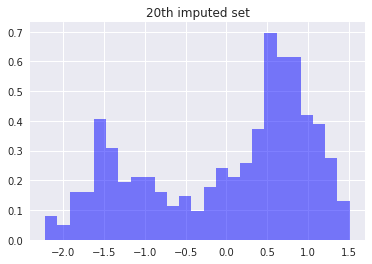

In [8]:
# histogram based on pca values for each of the imputed set
impute = ['V'+str(i) for i in range(1, 21)]

for i in range(len(impute)):
    data = StandardScaler().fit_transform(pnas_data2.loc[:, [impute[i]]].values)
    # filtered_pnas1 = pnas_data1.loc[:, features].values
    num_bins = 25

    # the histogram/gaussian mixture model of the data
    n, bins, patches = plt.hist(data, num_bins, normed=1, facecolor='blue', alpha=0.5)
    
    plt.title(str(i+1)+"th imputed set")
    plt.legend()
    plt.show()
    plt.close()

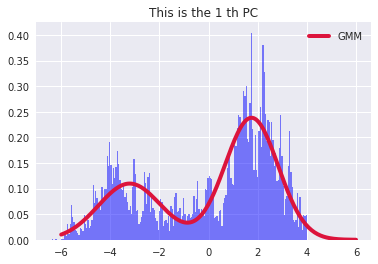

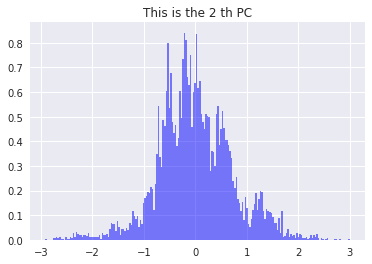

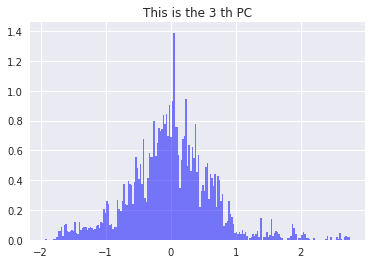

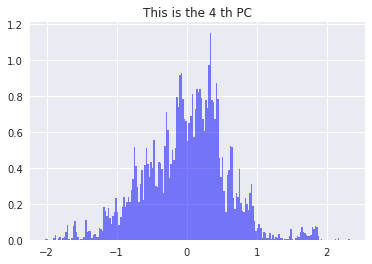

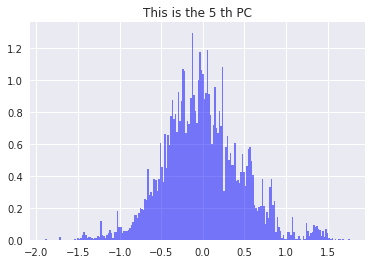

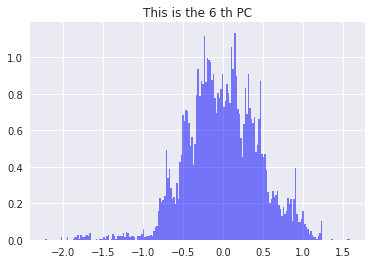

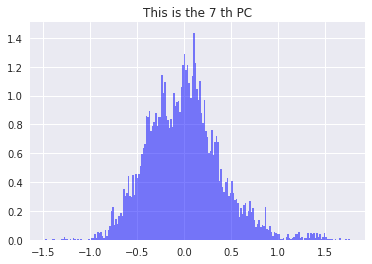

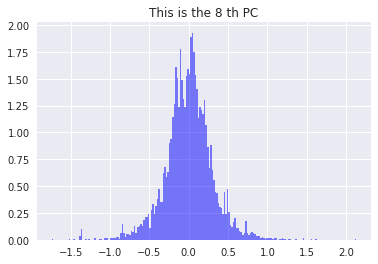

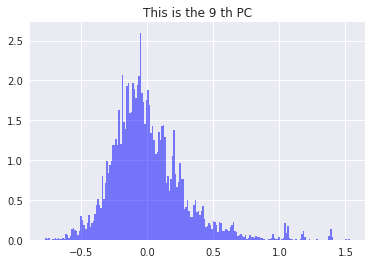

In [30]:
# histogram for 20 imputed sets combined 

num_bins = 200
mu = 0 # mean (data is centered)

#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

# Evaluate GMM
gmm_x = np.linspace(-6, 6, 200)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

# the histogram/gaussian mixture model of the data for each of the principal component
for i in range(9):
    if i == 0:
        fig, ax = plt.subplots()
        ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

    n, bins, patches = plt.hist(data[:,i], num_bins, normed=1, facecolor='blue', alpha=0.5)

    plt.title('This is the %s th PC'% str(int(i)+1))
    plt.legend()
    plt.show()
    plt.close()

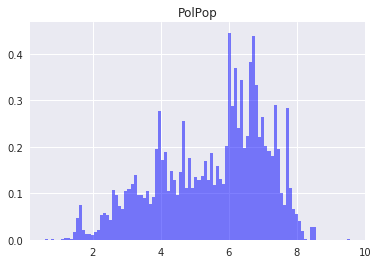

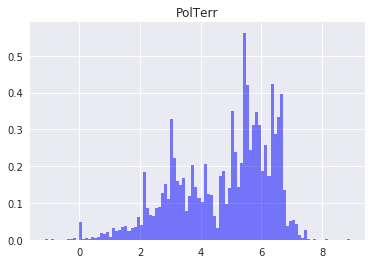

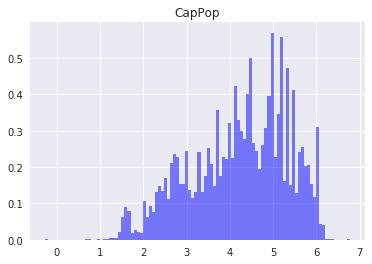

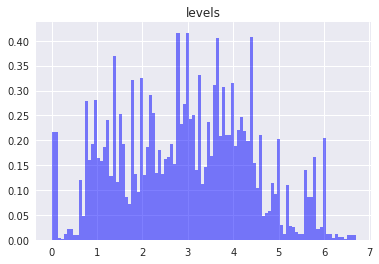

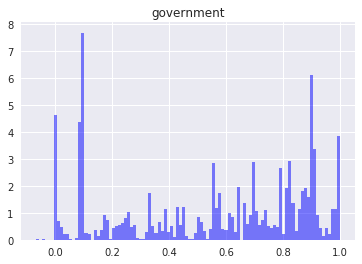

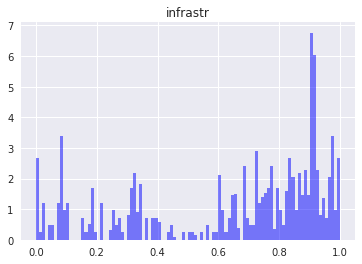

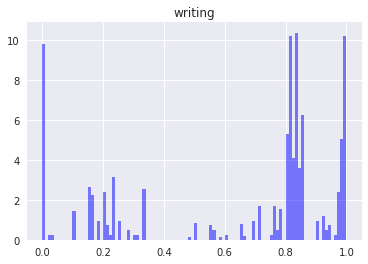

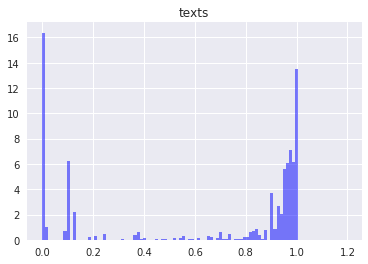

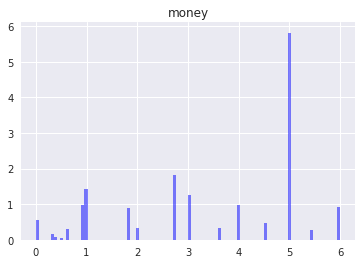

In [29]:
# histogram for each CCs

num_bins = 100

for cc in range(9): 
    n, bins, patches = plt.hist(data_mat[:, cc], num_bins, normed=1, facecolor='blue', alpha=0.5)
    plt.title(features[cc])
    plt.legend()
    plt.show()
    plt.close()

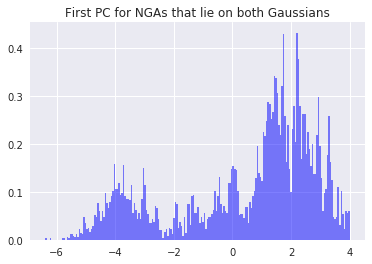

In [70]:
# histogram for NGAs that span both Gaussians

#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

# mean and covariance for each component
gauss_one = gmm.weights_[0] #weight for gaussian distribution
gauss_two = gmm.weights_[1] #weight for gaussian distribution 

idx_data = sorted(range(len(data[:,0])), key = lambda i: data[:,0][i]) #sort data points by their values on principal axis
prob_distr = gmm.predict_proba(X=np.expand_dims(sorted(data[:,0]), 1)) #probability distribution for gaussians on principal axis
lower = list()
higher = list()

for idx in range(len(prob_distr)):
    if gmm.weights_[0] < gmm.weights_[1]:
        if prob_distr[idx][0] >= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])
    else:
        if prob_distr[idx][0] <= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])

both_ngas = list()
# return polities that lie in both Gaussians for each imputed set
for i in range(1,21):
    impute = pnas_data1[pnas_data1.irep == i]
    lower_df = impute.loc[lower].dropna()
    higher_df = impute.loc[higher].dropna()

    unique_nga = [j for j in impute.NGA.unique().tolist() if (j in lower_df.NGA.unique().tolist()
                                                         and j in higher_df.NGA.unique().tolist())]
    nga_gauss = impute.loc[pnas_data1['NGA'].isin(unique_nga)]
    both_gauss = np.take(data[:,0], nga_gauss.index.values)
    both_ngas.append(both_gauss)

for i in range(len(both_ngas)-1):
    ngas = np.concatenate((both_ngas[i], both_ngas[i+1]), axis=0)
    both_ngas[i+1] = ngas
    
num_bins = 200

n, bins, patches = plt.hist(ngas, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('First PC for NGAs that lie on both Gaussians')
plt.legend()
plt.show()
plt.close()


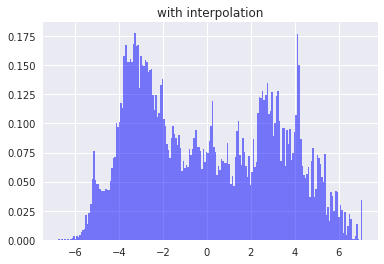

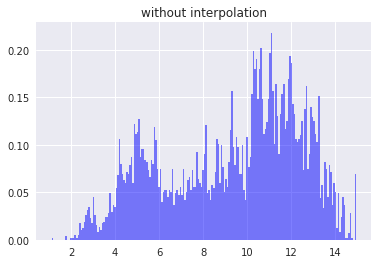

In [32]:
# linear interpolation of missing time periods 
time_features = features + ['Time']
data = pnas_data1.loc[:, features].values


added_rows = list()
for impute_step in range(1, 21):
    # 1) polity-based interpolation
    impute_set = pnas_data1[pnas_data1.irep==impute_step]
    unique_region = impute_set.NGA.unique().tolist()

    for nga in unique_region:
        times = sorted(impute_set[impute_set.NGA == nga].Time.unique().tolist())
        if len(times) != ((max(times)-min(times))/100)+1:

            for time in range(len(times)-1):
                if times[time+1]-times[time] != 100:

                    # linear interpolation
                    feature_val1 = impute_set[(impute_set.NGA == nga) & 
                                               (impute_set.Time == times[time])].loc[:, features].values.tolist()[0]
                    feature_val2 = impute_set[(impute_set.NGA == nga) & 
                                               (impute_set.Time == times[time+1])].loc[:, features].values.tolist()[0]
                    diff = [i-j for i,j in zip(feature_val2, feature_val1)]
                    num_steps = int((times[time+1]-times[time])/100)

                    for i in range(1, num_steps):
                        diff_step = [(i/num_steps)*j for j in diff]
                        interpol = [k+l for k, l in zip(diff_step, feature_val1)]
                        added_rows.append(interpol)

added_rows = np.asarray(added_rows)
data_matrix = np.vstack((data, added_rows)) # add interpolated rows to the original data matrix
P, D, Q = svd(data_matrix)
proj = np.matmul(data_matrix, Q.T[:,0]) # project interpolated rows (as well as the original data) on principal axis
init = np.matmul(data, Q.T[:,0])

num_bins = 200

n, bins, patches = plt.hist(proj, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('with interpolation')
plt.legend()
plt.show()
plt.close()

n, bins, patches = plt.hist(init, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('without interpolation')
plt.legend()
plt.show()
plt.close()